In [1]:
import jax
import sys

import numpy as np
import matplotlib.pyplot as plt

from utils_rings import _generate_data

sys.path.append("../")
from lib_jax.sliced_busemann_1d_jax import busemann_sliced_1d
from lib_jax.sliced_otdd_jax import sliced_otdd
from lib_jax.sliced_busemann_gaussian_jax import busemann_sliced_gaussian_approx
from lib_jax.gd import wasserstein_gradient_descent_jit

### Plot Rings

In [2]:
X, Y = _generate_data()
X = np.concatenate([X[:,1][:,None], X[:,0][:,None]], axis=-1)
Y = np.concatenate([Y[:,1][:,None], Y[:,0][:,None]], axis=-1)

X_data = np.zeros((3, 80, 2))
X_data[0] = X[:80]
X_data[1] = X[80:160]
X_data[2] = X[160:]

x0 = np.zeros((3, 80, 2))
x0[0] = Y[:80]
x0[1] = Y[80:160]
x0[2] = Y[160:]

In [6]:
def plot_row_rings(L1, X, ax, iters=[0, 10, 25, 100], ylabel=None, set_title=False):
    """
        ax: shape len(iters)
    """
    
    # f, axs = plt.subplots(nrows=2, ncols=4, figsize=(15, 4))

    m = L1[0].shape[0]
    
    for i, k in enumerate(iters):
        ax[i].scatter(X[:,0],X[:,1],label="Target")

        for j in range(m):
            ax[i].scatter(L1[k][j,:,0],L1[k][j,:,1])

        if set_title:
            ax[i].set_title("Iter "+str(k//2), fontsize=13, pad=-15)
        
        ax[i].set_xlim([-1.9, 0.4])
        ax[i].set_ylim([-0.6, 0.6])
        ax[i].set_aspect("equal")

        # Remove spines instead of using set_frame_on(False)
        for spine in ['top', 'right', 'left', 'bottom']:
            ax[i].spines[spine].set_visible(False)

        # Remove ticks
        ax[i].tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)
        
    ax[0].set_ylabel(ylabel, fontsize=13, usetex=True) #, rotation=0, labelpad=10)

### Wasserstein over Wasserstein Gradient Flows

In [3]:
rng = jax.random.PRNGKey(0)
master_key, key = jax.random.split(rng, num=2)

def target_value_and_grad(x, y, rng, n_projs=500):
    n, n_samples, _ = x.shape

    tgt_func = lambda z: busemann_sliced_1d(rng, z, y, n_projs)
    l, grad = jax.value_and_grad(tgt_func)(x)
    return l, n * n_samples * grad

n_epochs = 1001
L_loss, L_particles_swb1dg = wasserstein_gradient_descent_jit(x0, X_data, jax.jit(target_value_and_grad),
                                                              key, n_epochs=n_epochs, lr=0.5)

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


  0%|          | 0/1001 [00:00<?, ?it/s]

In [4]:
rng = jax.random.PRNGKey(0)
master_key, key = jax.random.split(rng, num=2)

def target_value_and_grad(x, y, rng, n_projs=500):
    n, n_samples, _ = x.shape

    tgt_func = lambda z: sliced_otdd(rng, z, y, n_projs)
    l, grad = jax.value_and_grad(tgt_func)(x)
    return l, n * n_samples * grad

n_epochs = 1001
L_loss, L_particles_sotdd = wasserstein_gradient_descent_jit(x0, X_data, jax.jit(target_value_and_grad),
                                                             key, n_epochs=n_epochs, lr=0.5)

  0%|          | 0/1001 [00:00<?, ?it/s]

In [5]:
rng = jax.random.PRNGKey(0)
master_key, key = jax.random.split(rng, num=2)

def target_value_and_grad(x, y, rng, n_projs=500):
    n, n_samples, _ = x.shape

    tgt_func = lambda z: busemann_sliced_gaussian_approx(z, y, rng, n_projs)
    l, grad = jax.value_and_grad(tgt_func)(x)
    return l, n * n_samples * grad

n_epochs = 1001
L_loss, L_particles_swbg = wasserstein_gradient_descent_jit(x0, X_data, jax.jit(target_value_and_grad), key, n_epochs=n_epochs, lr=0.5)

  0%|          | 0/1001 [00:00<?, ?it/s]

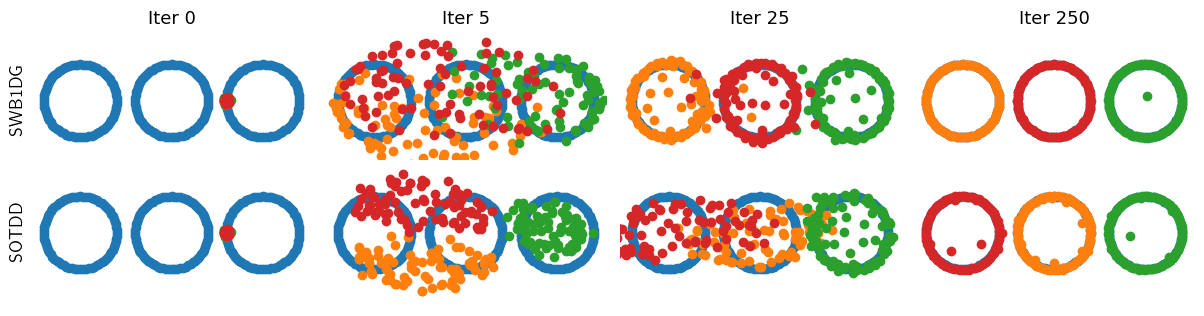

In [ ]:
L_iters = [0, 10, 50, 500]

fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(15, 4))
plot_row_rings(L_particles_swb1dg, X, ax[0], iters=L_iters, ylabel="SWB1DG", set_title=True)
plot_row_rings(L_particles_sotdd, X, ax[1], iters=L_iters, ylabel="SOTDD")

plt.subplots_adjust(wspace=0.05, hspace=-0.25)

# plt.savefig("Rings_comparison.pdf", format="pdf", bbox_inches="tight")

plt.show()

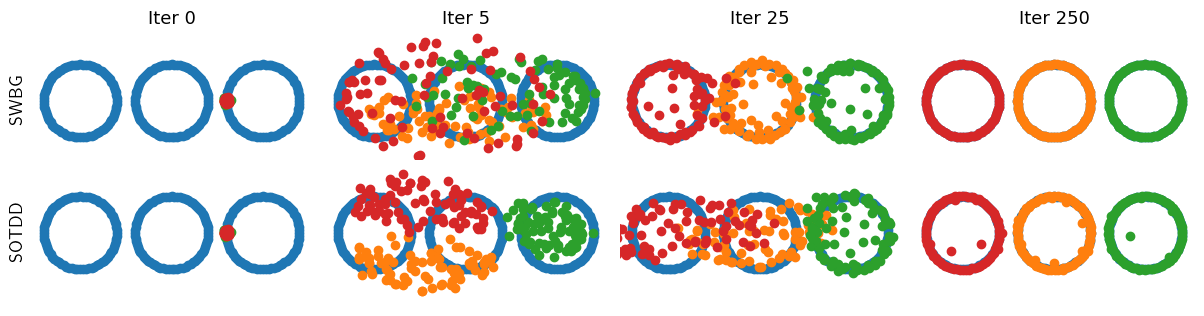

In [ ]:
fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(15, 4))
plot_row_rings(L_particles_swbg, X, ax[0], iters=L_iters, ylabel="SWBG", set_title=True)
plot_row_rings(L_particles_sotdd, X, ax[1], iters=L_iters, ylabel="SOTDD")

plt.subplots_adjust(wspace=0.05, hspace=-0.25)

# plt.savefig("Rings_comparison_swbg_vs_sotdd.pdf", format="pdf", bbox_inches="tight")

plt.show()

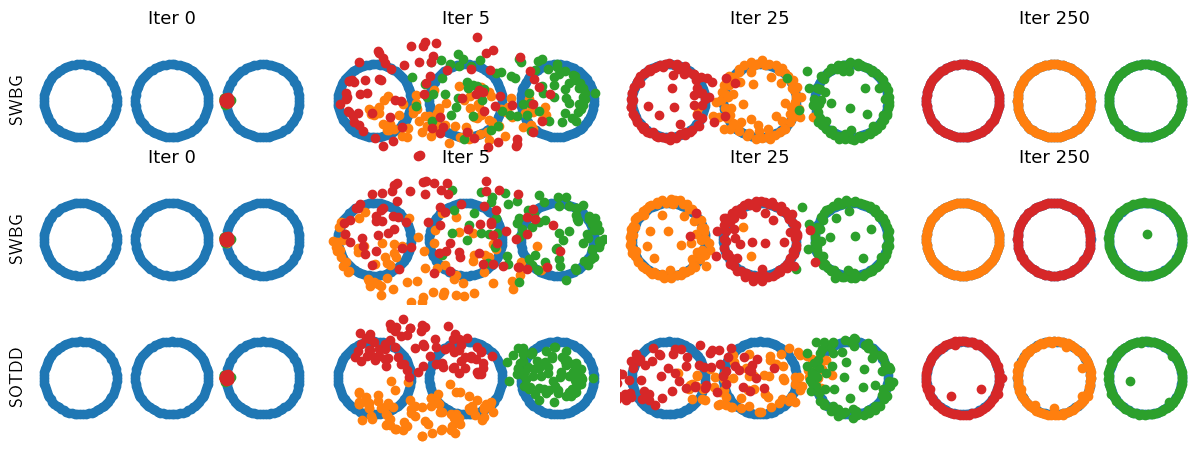

In [ ]:
fig, ax = plt.subplots(nrows=3, ncols=4, figsize=(15, 6))
plot_row_rings(L_particles_swbg, X, ax[0], iters=L_iters, ylabel="SWBG", set_title=True)
plot_row_rings(L_particles_swb1dg, X, ax[1], iters=L_iters, ylabel="SWBG", set_title=True)
plot_row_rings(L_particles_sotdd, X, ax[2], iters=L_iters, ylabel="SOTDD")

plt.subplots_adjust(wspace=0.05, hspace=-0.25)

# plt.savefig("Rings_comparison.pdf", format="pdf", bbox_inches="tight")
# plt.savefig("Rings_comparison_all.pdf", format="pdf", bbox_inches="tight")

plt.show()